
# Training a SFNO on the spherical Shallow Water equations

Using the small Spherical Shallow Water Equations example we ship with the package
to train a Spherical Fourier-Neural Operator (SFNO).

This tutorial demonstrates how to train neural operators on spherical domains, which is
crucial for many geophysical applications like weather prediction, ocean modeling, and
climate science. The SFNO extends the FNO architecture to handle data on the sphere
using spherical harmonics instead of regular Fourier modes.

The Shallow Water Equations describe the motion of a thin layer of fluid and are
fundamental in atmospheric and oceanic dynamics.


.. raw:: html

   <div style="margin-top: 3em;"></div>

## Import dependencies
We import the necessary modules for training a Spherical Fourier Neural Operator



In [ ]:
!pip install neuraloperator -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 44.9 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/neuraloperator/neuraloperator


Cloning into 'neuraloperator'...
remote: Enumerating objects: 14575, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 14575 (delta 0), reused 0 (delta 0), pack-reused 14569 (from 1)
Receiving objects: 100% (14575/14575), 106.59 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (9691/9691), done.


In [ ]:
!pip install -r neuraloperator/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 129.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 140.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 9.5 MB/s eta 0:00:00
  Created wheel for torch-harmonics: filename=torch_harmonics-0.8.0-py3-none-any.whl size=162234 sha256=c3e877fb900b20d86994d609a13a5e19b96a8bff4e20e9842918f8aba951f8d6
  Stored in directory: /root/.cache/pip/wheels/de/35/f6/520d03aca1fd51fda6281591e12d15bfee315dc12de5b0a4af
Successfully built torch-harmonics


In [ ]:
import torch
import matplotlib.pyplot as plt
import sys
from neuraloperator.neuralop.models import SFNO
from neuraloperator.neuralop import Trainer
from neuraloperator.neuralop.training import AdamW
from neuraloperator.neuralop.data.datasets import load_spherical_swe
from neuraloperator.neuralop.utils import count_model_params
from neuraloperator.neuralop import LpLoss, H1Loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Loading the Spherical Shallow Water Equations dataset
We load the spherical shallow water equations dataset with multiple resolutions.
The dataset contains velocity and height fields on the sphere, which are the
fundamental variables in shallow water dynamics.



In [ ]:
train_loader, test_loaders = load_spherical_swe(
    n_train=1,
    batch_size=64,
    train_resolution=(64, 128),
    test_resolutions=[(64, 128), (128, 256)],
    n_tests=[4, 4],
    test_batch_sizes=[40, 40],
)

Loading train dataloader at resolution (64, 128) with 1 samples and batch-size=64
Loading test dataloader at resolution (64, 128) with 4 samples and batch-size=40
Loading test dataloader at resolution (128, 256) with 4 samples and batch-size=40


.. raw:: html

   <div style="margin-top: 3em;"></div>

## Creating the Spherical FNO model



In [ ]:
model = SFNO(
    n_modes=(32, 64),
    in_channels=3,
    out_channels=3,
    hidden_channels=128,
    domain_padding=[0.05, 0.05],
    n_layers=2,
)
model = model.to(device)

# Count and display the number of parameters
n_params = count_model_params(model)
print(f"\nOur model has {n_params} parameters.")
sys.stdout.flush()


Our model has 2231811 parameters.


In [ ]:
model_path = '/content/model_state_dict_sfno_high.pt'
model.load_state_dict(torch.load(model_path, map_location=device , weights_only = False))
model = model.to(device)

In [ ]:
model

SFNO(
  (positional_embedding): GridEmbeddingND()
  (domain_padding): DomainPadding()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-1): 2 x SphericalConv(
        (weight): ComplexDenseTensor(shape=torch.Size([128, 128, 32]), rank=None)
        (sht_handle): SHT(
          (_SHT_cache): ModuleDict()
          (_iSHT_cache): ModuleDict()
        )
      )
    )
    (fno_skips): ModuleList(
      (0-1): 2 x Flattened1dConv(
        (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-1): 2 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-1): 2 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(5, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 128, kernel_size=(1,), stride

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Creating the optimizer and scheduler
We use AdamW optimizer with a lower learning rate for spherical data



In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Setting up loss functions
For spherical data, we use L2 loss with sum reduction to handle the varying
grid sizes across different latitudes on the sphere



In [ ]:
l2loss = LpLoss(d=2, p=2, reduction="sum")

train_loss = l2loss
eval_losses = {"l2": l2loss}

In [ ]:
print("\n### MODEL ###\n", model)
print("\n### OPTIMIZER ###\n", optimizer)
print("\n### SCHEDULER ###\n", scheduler)
print("\n### LOSSES ###")
print(f"\n * Train: {train_loss}")
print(f"\n * Test: {eval_losses}")
sys.stdout.flush()


### MODEL ###
 SFNO(
  (positional_embedding): GridEmbeddingND()
  (domain_padding): DomainPadding()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-1): 2 x SphericalConv(
        (weight): ComplexDenseTensor(shape=torch.Size([128, 128, 32]), rank=None)
        (sht_handle): SHT(
          (_SHT_cache): ModuleDict()
          (_iSHT_cache): ModuleDict()
        )
      )
    )
    (fno_skips): ModuleList(
      (0-1): 2 x Flattened1dConv(
        (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-1): 2 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-1): 2 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(5, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 128, kernel_s

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Creating the trainer
We create a Trainer object that handles the training loop for spherical data



In [ ]:
trainer = Trainer(
    model=model,
    n_epochs=30,
    device=device,
    wandb_log=False,  # Disable Weights & Biases logging
    eval_interval=5,  # Evaluate every 5 epochs
    use_distributed=False,  # Single GPU/CPU training
    verbose=True,  # Print training progress
)

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Training the SFNO model
We train the model on the spherical shallow water equations dataset.
The trainer will handle the forward pass through the SFNO, compute the L2 loss,
backpropagate, and evaluate on test data.



In [ ]:
trainer.train(
    train_loader=train_loader,
    test_loaders=test_loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
    save_every=5,
    save_dir="./high_checkpoints",
)

Training on 2000 samples
Testing on [400, 400] samples         on resolutions [(64, 128), (128, 256)].
Raw outputs of shape torch.Size([64, 3, 64, 128])
[0] time=97.48, avg_loss=0.4169, train_err=26.0587
Eval: (64, 128)_l2=0.4839, (128, 256)_l2=2.2621
[Rank 0]: saved training state to ./high_checkpoints
[5] time=97.66, avg_loss=0.2403, train_err=15.0214
Eval: (64, 128)_l2=0.3220, (128, 256)_l2=2.2074
[Rank 0]: saved training state to ./high_checkpoints
[10] time=98.15, avg_loss=0.1727, train_err=10.7922
Eval: (64, 128)_l2=0.2594, (128, 256)_l2=2.2144
[Rank 0]: saved training state to ./high_checkpoints
[15] time=99.36, avg_loss=0.1264, train_err=7.9002
Eval: (64, 128)_l2=0.2100, (128, 256)_l2=2.1810
[Rank 0]: saved training state to ./high_checkpoints
[20] time=98.13, avg_loss=0.0988, train_err=6.1731
Eval: (64, 128)_l2=0.1480, (128, 256)_l2=2.1734
[Rank 0]: saved training state to ./high_checkpoints
[25] time=98.64, avg_loss=0.0842, train_err=5.2654
Eval: (64, 128)_l2=0.1347, (128, 25

{'train_err': 5.1062317825853825,
 'avg_loss': 0.08169970852136611,
 'avg_lasso_loss': None,
 'epoch_train_time': 97.72053474299992}

.. raw:: html

   <div style="margin-top: 3em;"></div>

## Visualizing SFNO predictions on spherical data
We visualize the model's predictions on spherical shallow water equations data.
Note that we trained on a very small resolution for a very small number of epochs.
In practice, we would train at larger resolution on many more samples.

However, for practicality, we created a minimal example that:
i) fits in just a few MB of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



In [ ]:
test_samples = test_loaders[(64,128)].dataset

In [ ]:
len(test_samples)

4

In [ ]:
t1 = torch.stack([test_samples[0]['x'] , test_samples[1]['x']] , dim=0)
save_path = r"/content/t1_swe.pt"
torch.save(t1 , save_path)

In [ ]:
t2 = torch.stack([test_samples[2]['x'] , test_samples[3]['x']] , dim=0)
save_path = r"/content/t2_swe.pt"
torch.save(t2 , save_path)

In [ ]:
import torch
import os

# Example: directory where you want to save tensors
save_dir = r"/content/swe_test_tensors"

# Create directory if it doesn’t exist
os.makedirs(save_dir, exist_ok=True)

# How many samples to save
num_samples = 50

# Ensure we don’t exceed available samples
num_samples = min(num_samples, len(test_samples))

# Loop through and save tensors
for i in range(num_samples):
    sample = test_samples[i]
    x_tensor = sample["x"]
    y_tensor = sample["y"]

    # Define paths
    x_path = os.path.join(save_dir, f"x_{i:03d}.pt")
    y_path = os.path.join(save_dir, f"y_{i:03d}.pt")

    # Save tensors
    torch.save(x_tensor, x_path)
    torch.save(y_tensor, y_path)

print(f"✅ Saved {num_samples} x/y tensor pairs in: {save_dir}")


✅ Saved 4 x/y tensor pairs in: /content/swe_test_tensors


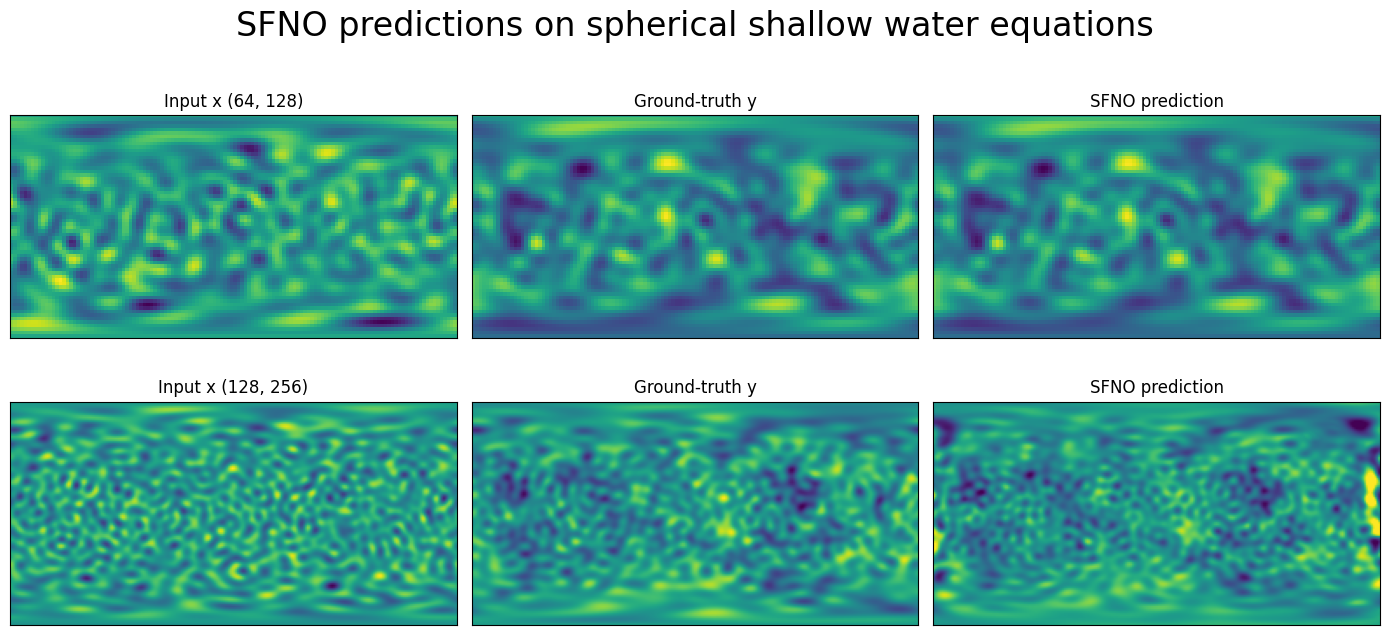

In [ ]:
fig = plt.figure(figsize=(14, 7))
for index, resolution in enumerate([ (64, 128) , (128 , 256)]):
    test_samples = test_loaders[resolution].dataset
    data = test_samples[0]
    # Input x
    x = data["x"]
    # Ground-truth
    y = data["y"][0, ...].numpy()
    # Model prediction: SFNO output
    x_in = x.unsqueeze(0).to(device)
    out = model(x_in).squeeze()[0, ...].detach().cpu().numpy()
    x = x[0, ...].detach().numpy()

    # Plot input fields
    ax = fig.add_subplot(2, 3, index * 3 + 1)
    ax.imshow(x)
    ax.set_title(f"Input x {resolution}")
    plt.xticks([], [])
    plt.yticks([], [])

    # Compute the min and max to use consistent color mapping
    vmin = y.min()
    vmax = y.max()

    # Plot ground-truth fields
    ax = fig.add_subplot(2, 3, index * 3 + 2)
    im_gt = ax.imshow(y, vmin=vmin, vmax=vmax)
    ax.set_title("Ground-truth y")
    plt.xticks([], [])
    plt.yticks([], [])

    # Plot model prediction
    ax = fig.add_subplot(2, 3, index * 3 + 3)
    im_pred = ax.imshow(out, vmin=vmin, vmax=vmax)
    ax.set_title("SFNO prediction")
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle("SFNO predictions on spherical shallow water equations", y=0.98, fontsize=24)
plt.tight_layout()
fig.show()